In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
cd /content/drive/MyDrive/Summer_School_AT2025

/content/drive/MyDrive/Summer_School_AT2025


In [ ]:
ls

models/  prediction_voxelmorph.py  trained_weights/  utils/  val/


In [ ]:
pip install SimpleITK

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.6/52.6 MB 18.3 MB/s eta 0:00:00


In [ ]:
pip install pystrum

  Preparing metadata (setup.py) ... done
  Created wheel for pystrum: filename=pystrum-0.4-py3-none-any.whl size=19533 sha256=526922986002b2f2d844c5d40f11cfec5e0cb42888fa2aee84e01129ad532011
  Stored in directory: /root/.cache/pip/wheels/63/78/20/a9053c8a842b1513a5e23159a2210dfa6bb0b225e72d175dd1
Successfully built pystrum


In [ ]:
import os
import torch
import torch.nn as nn
import nibabel as nib
import numpy as np
import SimpleITK as sitk
from skimage.transform import resize
from models.vxm_model import VxmDenseSimple
from models.spatial_transformer import RegisterModel
from utils.utils import dice_val_substruct, dice_val

In [ ]:
# -------------------- Utility Functions --------------------
import pystrum.pynd.ndutils as nd
def jacobian_determinant_vxm(disp):
    """
    jacobian determinant of a displacement field.
    NB: to compute the spatial gradients, we use np.gradient.
    Parameters:
        disp: 2D or 3D displacement field of size [*vol_shape, nb_dims],
              where vol_shape is of len nb_dims
    Returns:
        jacobian determinant (scalar)
    """

    # check inputs
    disp = disp.transpose(1, 2, 3, 0)
    volshape = disp.shape[:-1]
    nb_dims = len(volshape)
    assert len(volshape) in (2, 3), 'flow has to be 2D or 3D'

    # compute grid
    grid_lst = nd.volsize2ndgrid(volshape)
    grid = np.stack(grid_lst, len(volshape))

    # compute gradients
    J = np.gradient(disp + grid)

    # 3D glow
    if nb_dims == 3:
        dx = J[0]
        dy = J[1]
        dz = J[2]

        # compute jacobian components
        Jdet0 = dx[..., 0] * (dy[..., 1] * dz[..., 2] - dy[..., 2] * dz[..., 1])
        Jdet1 = dx[..., 1] * (dy[..., 0] * dz[..., 2] - dy[..., 2] * dz[..., 0])
        Jdet2 = dx[..., 2] * (dy[..., 0] * dz[..., 1] - dy[..., 1] * dz[..., 0])

        return Jdet0 - Jdet1 + Jdet2

    else:  # must be 2

        dfdx = J[0]
        dfdy = J[1]

        return dfdx[..., 0] * dfdy[..., 1] - dfdy[..., 0] * dfdx[..., 1]

In [ ]:
# -------------------- Model Setup --------------------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
img_size = (128,128,16)
model = VxmDenseSimple(inshape=img_size).to(device)
reg_model = RegisterModel(img_size, 'nearest').to(device)

/usr/local/lib/python3.12/dist-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4322.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
# -------------------- Load checkpoint --------------------
checkpoint_path = '/content/drive/MyDrive/Summer_School_AT2025/trained_weights/dsc0.6097.pth.tar'  # adjust your checkpoint
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['state_dict'])
    print("Loaded trained model.")
else:
    raise FileNotFoundError(f"{checkpoint_path} not found!")

model.eval()

Loaded trained model.


VxmDenseSimple(
  (unet): SimpleUnet3D(
    (enc1): ConvBlock(
      (block): Sequential(
        (0): Conv3d(2, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv3d(16, 16, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (enc2): ConvBlock(
      (block): Sequential(
        (0): Conv3d(16, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (3): LeakyReLU(negative_slope=0.2, inplace=True)
      )
    )
    (enc3): ConvBlock(
      (block): Sequential(
        (0): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
        (1): LeakyReLU(negative_slope=0.2, inplace=True)
        (2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=

In [ ]:
val_dir = "/content/drive/MyDrive/Summer_School_AT2025/val"

In [ ]:
################ create output paths ######################
output_dir = "/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/"
save_pathm = os.path.join(output_dir, 'moved')
save_pathf = os.path.join(output_dir, 'flowf')
save_pathjf = os.path.join(output_dir, 'jfield')
save_pathseg = os.path.join(output_dir, 'segout')
fixedimpath = os.path.join(output_dir, 'fixed')
movedimpath = os.path.join(output_dir, 'moving')
fixedlabelpa = os.path.join(output_dir, 'fixed_label')
movedlabelpa = os.path.join(output_dir, 'move_label')

for p in [save_pathm, save_pathf, save_pathjf, save_pathseg,
          fixedimpath, movedimpath, fixedlabelpa, movedlabelpa]:
    os.makedirs(p, exist_ok=True)

In [ ]:
# -------------------- Process Patients --------------------
import os
import numpy as np
import torch
import torch.nn as nn
import nibabel as nib
import SimpleITK as sitk
from skimage.transform import resize
# -------------------- Process Patients --------------------
patients = sorted(list(set([f.split('_')[0] for f in os.listdir(val_dir)])))

for pat in patients:
    # Paths
    fixed_path = os.path.join(val_dir, f'{pat}_ED.nii.gz')
    moving_path = os.path.join(val_dir, f'{pat}_ES.nii.gz')
    fixed_label_path = os.path.join(val_dir, f'{pat}_ED_gt.nii.gz')
    moving_label_path = os.path.join(val_dir, f'{pat}_ES_gt.nii.gz')

    # Read images with SimpleITK for array processing
    fixed_img = sitk.GetArrayFromImage(sitk.ReadImage(fixed_path)).swapaxes(0, 2)
    moving_img = sitk.GetArrayFromImage(sitk.ReadImage(moving_path)).swapaxes(0, 2)
    fixed_label = sitk.GetArrayFromImage(sitk.ReadImage(fixed_label_path)).swapaxes(0, 2)
    moving_label = sitk.GetArrayFromImage(sitk.ReadImage(moving_label_path)).swapaxes(0, 2)

    # Read images with nibabel to get original affine
    fixed_img_nii = nib.load(fixed_path)
    moving_img_nii = nib.load(moving_path)
    fixed_label_nii = nib.load(fixed_label_path)
    moving_label_nii = nib.load(moving_label_path)

    # Resize to target img_size
    fixed_img_r = resize(fixed_img, img_size, preserve_range=True, anti_aliasing=False, order=3)
    moving_img_r = resize(moving_img, img_size, preserve_range=True, anti_aliasing=False, order=3)
    fixed_label_r = resize(fixed_label, img_size, preserve_range=True, anti_aliasing=False, order=0)
    moving_label_r = resize(moving_label, img_size, preserve_range=True, anti_aliasing=False, order=0)

    # Save resized images and labels
    nib.save(nib.Nifti1Image(fixed_img_r.astype(np.float32), fixed_img_nii.affine),
             os.path.join(fixedimpath, f'{pat}_fixed.nii.gz'))
    nib.save(nib.Nifti1Image(moving_img_r.astype(np.float32), moving_img_nii.affine),
             os.path.join(movedimpath, f'{pat}_moving.nii.gz'))
    nib.save(nib.Nifti1Image(fixed_label_r.astype(np.uint8), fixed_label_nii.affine),
             os.path.join(fixedlabelpa, f'{pat}_fixed_label.nii.gz'))
    nib.save(nib.Nifti1Image(moving_label_r.astype(np.uint8), moving_label_nii.affine),
             os.path.join(movedlabelpa, f'{pat}_moving_label.nii.gz'))

    # Convert to torch tensors
    x = torch.from_numpy(fixed_img_r).unsqueeze(0).unsqueeze(0).float().to(device)
    y = torch.from_numpy(moving_img_r).unsqueeze(0).unsqueeze(0).float().to(device)
    x_seg = torch.from_numpy(fixed_label_r).unsqueeze(0).long().to(device)
    y_seg = torch.from_numpy(moving_label_r).unsqueeze(0).long().to(device)

    # Forward pass
    with torch.no_grad():
        x_in = torch.cat((x, y), dim=1)
        x_def, flow = model(x_in)

        # Save flow
        flow_np = flow.squeeze(0).cpu().numpy().astype(np.float32)
        np.save(os.path.join(save_pathf, f'{pat}_flow.npy'), flow_np)
        nib.save(nib.Nifti1Image(flow_np.transpose(3, 0, 1, 2), fixed_img_nii.affine),
                 os.path.join(save_pathf, f'{pat}_flow.nii.gz'))

        # Jacobian
        jac_det = jacobian_determinant_vxm(flow_np).astype(np.float32)
        np.save(os.path.join(save_pathjf, f'{pat}_jacobian.npy'), jac_det)
        nib.save(nib.Nifti1Image(jac_det, fixed_img_nii.affine),
                 os.path.join(save_pathjf, f'{pat}_jacobian.nii.gz'))

        # Deformed segmentation
        y_seg_oh = nn.functional.one_hot(y_seg, num_classes=4).permute(0, 4, 1, 2, 3).float()
        x_segs = []
        for i in range(4):
            def_seg = reg_model([y_seg_oh[:, i:i+1], flow])
            x_segs.append(def_seg)
        x_segs = torch.cat(x_segs, dim=1)
        def_out = torch.argmax(x_segs, dim=1)
        def_out_np = def_out.squeeze(0).cpu().numpy().astype(np.uint8)
        np.save(os.path.join(save_pathseg, f'{pat}_def_seg.npy'), def_out_np)
        nib.save(nib.Nifti1Image(def_out_np, fixed_img_nii.affine),
                 os.path.join(save_pathseg, f'{pat}_def_seg.nii.gz'))

        # Deformed image
        moved_np = x_def.squeeze(0).squeeze(0).cpu().numpy().astype(np.float32)
        np.save(os.path.join(save_pathm, f'{pat}_moved.npy'), moved_np)
        nib.save(nib.Nifti1Image(moved_np, fixed_img_nii.affine),
                 os.path.join(save_pathm, f'{pat}_moved.nii.gz'))

    print(f"Processed {pat}")


Processed patient001
Processed patient005
Processed patient011
Processed patient013
Processed patient019
Processed patient023
Processed patient027
Processed patient032
Processed patient041
Processed patient043
Processed patient045
Processed patient048
Processed patient063
Processed patient065
Processed patient074
Processed patient076
Processed patient082
Processed patient084
Processed patient091
Processed patient095


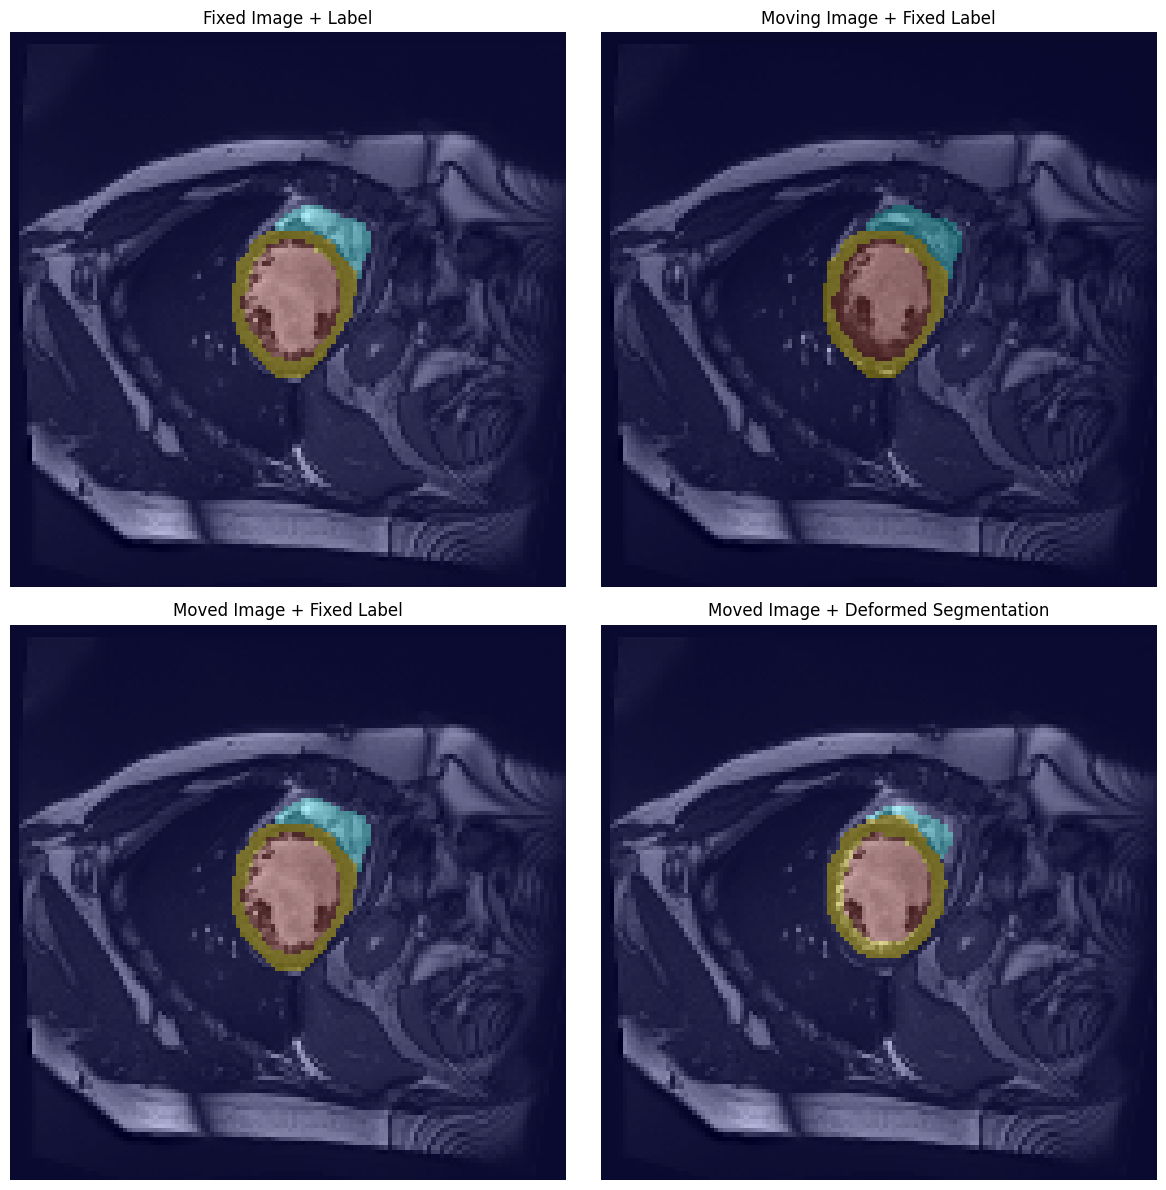

In [4]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
fixedimpath='/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/fixed'
movedimpath='/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/moving'
save_pathm='/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/moved'
fixedlabelpa='/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/fixed_label'
save_pathseg='/content/drive/MyDrive/Summer_School_AT2025/output_model_voxmorph/segout'

# -------------------- Load files for a single patient --------------------
patient_id = "patient001"  # example
fixed_path = f"{fixedimpath}/{patient_id}_fixed.nii.gz"
moving_path = f"{movedimpath}/{patient_id}_moving.nii.gz"
moved_path = f"{save_pathm}/{patient_id}_moved.nii.gz"
fixed_label_path = f"{fixedlabelpa}/{patient_id}_fixed_label.nii.gz"
def_seg_path = f"{save_pathseg}/{patient_id}_def_seg.nii.gz"

# Load images
fixed_img = nib.load(fixed_path).get_fdata()
moving_img = nib.load(moving_path).get_fdata()
moved_img = nib.load(moved_path).get_fdata()
fixed_label = nib.load(fixed_label_path).get_fdata()
def_seg = nib.load(def_seg_path).get_fdata()

# Choose a slice to visualize (middle slice in z-axis)
slice_idx = fixed_img.shape[2] // 2

# -------------------- Plot overlay --------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Fixed image with fixed label
axes[0,0].imshow(fixed_img[:,:,slice_idx], cmap='gray')
axes[0,0].imshow(fixed_label[:,:,slice_idx], cmap='jet', alpha=0.3)
axes[0,0].set_title("Fixed Image + Label")

# Moving image with fixed label
axes[0,1].imshow(moving_img[:,:,slice_idx], cmap='gray')
axes[0,1].imshow(fixed_label[:,:,slice_idx], cmap='jet', alpha=0.3)
axes[0,1].set_title("Moving Image + Fixed Label")

# Moved (deformed) image with fixed label
axes[1,0].imshow(moved_img[:,:,slice_idx], cmap='gray')
axes[1,0].imshow(fixed_label[:,:,slice_idx], cmap='jet', alpha=0.3)
axes[1,0].set_title("Moved Image + Fixed Label")

# Deformed segmentation overlay
axes[1,1].imshow(moved_img[:,:,slice_idx], cmap='gray')
axes[1,1].imshow(def_seg[:,:,slice_idx], cmap='jet', alpha=0.3)
axes[1,1].set_title("Moved Image + Deformed Segmentation")

for ax in axes.flatten():
    ax.axis('off')

plt.tight_layout()
plt.show()

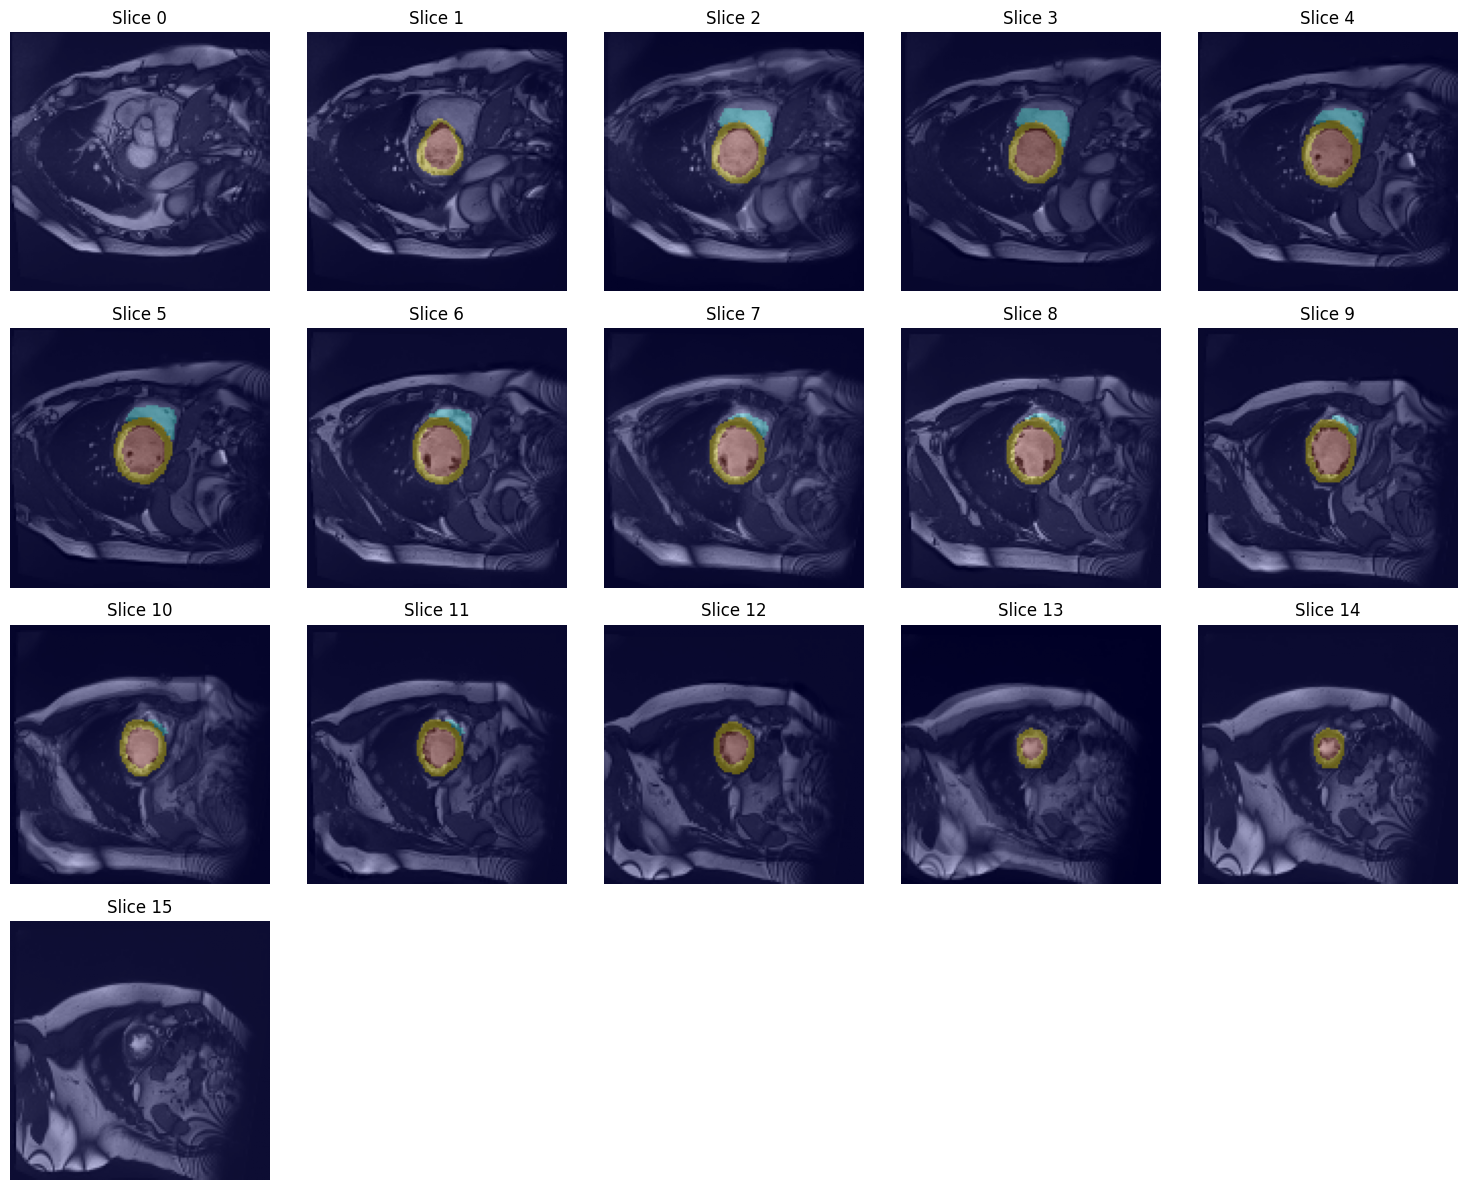

In [6]:

import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt

patient_id = "patient001"

# Load images
#fixed_img = nib.load(f"{fixedimpath}/{patient_id}_fixed.nii.gz").get_fdata()
moved_img = nib.load(f"{save_pathm}/{patient_id}_moved.nii.gz").get_fdata()
def_seg = nib.load(f"{save_pathseg}/{patient_id}_def_seg.nii.gz").get_fdata()

num_slices = fixed_img.shape[2]

# Set up grid
cols = 5
rows = int(np.ceil(num_slices / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, 3*rows))
axes = axes.flatten()

for i in range(num_slices):
    #axes[i].imshow(fixed_img[:,:,i], cmap='gray')
    axes[i].imshow(moved_img[:,:,i], cmap='gray')
    axes[i].imshow(def_seg[:,:,i], cmap='jet', alpha=0.3)
    axes[i].set_title(f"Slice {i}")
    axes[i].axis('off')

# Hide any extra axes
for j in range(num_slices, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
